In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from keras.initializers import GlorotUniform, HeUniform, HeNormal
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
!pip install tab2img -q # q for quiet
from tab2img.converter import Tab2Img
seed = 314159
np.random.seed(seed)
tf.random.set_seed(seed)

ERROR: Invalid requirement: '#'

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

from keras.datasets import cifar10, mnist
from keras.optimizers.legacy import SGD, Adam
from keras.utils import to_categorical
from keras.backend import image_data_format
from keras.applications.mobilenet import MobileNet
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Reshape
from keras.layers import Dense, Dropout, BatchNormalization


import matplotlib.pyplot as plt
import numpy as np
import copy

import csv
import random
import time

# Importing necessary libraries for preprocessing and modeling
import numpy as np
import pandas as pd
import warnings
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout


In [3]:
train_path = 'C:/Users/Mo-gh/Desktop/New folder/KDDTrain+.txt'
test_path = 'C:/Users/Mo-gh/Desktop/New folder/KDDTest+.txt'

In [4]:
def attack(row):
    if row['attack'] == 'normal':
        return 'normal'
    elif row['attack'] in ['port-Sweep', 'ip-Sweep', 'nmap', 'satan', 'saint', 'mscan']:
        return 'Probing'
    elif row['attack'] in ['neptune', 'smurf', 'pod', 'teardrop', 'land', 'back', 'apache2',
                          'udpstorm', 'processtable', ',mail-Bomb']:
        return 'Dos'
    elif row['attack'] in ['buffer-Overflow', 'load-Module', 'perl', 'rootkit', 'xterm',
                          'ps', 'sqlattack']:
        return 'U2R'
    else:
        return 'R2L'

In [5]:
Train_data = pd.read_csv(train_path)
Test_data = pd.read_csv(test_path)

# Drop the unnecessary columns
Train_data.drop('20', axis=1, inplace=True)
Test_data.drop('21', axis=1, inplace=True)

# Renaming columns
columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent',
            'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root',
            'num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login',
            'is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate',
            'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
            'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
            'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate',
            'dst_host_srv_rerror_rate','attack'])

Train_data.columns = columns
Test_data.columns = columns

Train_data.drop('num_outbound_cmds', axis=1, inplace=True)
Test_data.drop('num_outbound_cmds', axis=1, inplace=True)

Train_data['attack'] = Train_data.apply(attack, axis=1)
Test_data['attack'] = Test_data.apply(attack, axis=1)

# Label encoding categorical features
protocol_type_le = LabelEncoder()
service_le = LabelEncoder()
flag_le = LabelEncoder()

Train_data['protocol_type'] = protocol_type_le.fit_transform(Train_data['protocol_type'])
Train_data['service'] = service_le.fit_transform(Train_data['service'])
Train_data['flag'] = flag_le.fit_transform(Train_data['flag'])

Test_data['protocol_type'] = protocol_type_le.transform(Test_data['protocol_type'])
Test_data['service'] = service_le.transform(Test_data['service'])
Test_data['flag'] = flag_le.transform(Test_data['flag'])

# One-hot encoding the target variable
Train_data = pd.get_dummies(Train_data, columns=['attack'])
Test_data = pd.get_dummies(Test_data, columns=['attack'])

# Align Test_data columns to Train_data columns (to ensure same number of columns)
Test_data = Test_data.reindex(columns=Train_data.columns, fill_value=0)

# Selecting important features
ImportantFeatures = Train_data.columns[0:40]
x_train = Train_data[ImportantFeatures].values
y_train = Train_data[['attack_normal', 'attack_Probing', 'attack_Dos', 'attack_U2R', 'attack_R2L']].values.astype(int)

x_test = Test_data[ImportantFeatures].values
y_test = Test_data[['attack_normal', 'attack_Probing', 'attack_Dos', 'attack_U2R', 'attack_R2L']].values.astype(int)

# Verify the label encoding
print("Sample y_train before reshaping and conversion:")
print(y_train[:5])

# Verify the reshaping
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

Sample y_train before reshaping and conversion:
[[1 0 0 0 0]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 1 0 0]]
Shape of x_train: (125972, 40)
Shape of x_test: (22543, 40)


In [6]:
import numpy as np
import pandas as pd

# Assuming y_train and y_test are numpy arrays with one-hot encoded classes
# Define the class labels based on one-hot encoding
class_labels = ['attack_normal', 'attack_Probing', 'attack_Dos', 'attack_U2R', 'attack_R2L']

# Function to compute class distribution
def class_distribution(y):
    # Convert to DataFrame
    df = pd.DataFrame(y, columns=class_labels)
    # Sum across the rows to get the distribution of each class
    return df.sum()

# Compute class distribution for y_train and y_test
print("Class distribution in y_train:")
print(class_distribution(y_train))

print("Class distribution in y_test:")
print(class_distribution(y_test))


Class distribution in y_train:
attack_normal     67342
attack_Probing     5126
attack_Dos        45927
attack_U2R           13
attack_R2L         7564
dtype: int64
Class distribution in y_test:
attack_normal     9711
attack_Probing    2123
attack_Dos        7164
attack_U2R          45
attack_R2L        3500
dtype: int64


In [7]:
# Set seed
seed_pi = 31415

# Set numpy seed
np.random.seed(seed_pi)
# Set the seed for TensorFlow
tf.random.set_seed(seed_pi)

In [8]:
def extractAllSets(X,y,p_train,p_val,p_test,random_state=seed_pi,shuffle=True):
    # The initial train-test split produces X_train and y_train
    # Two additional sets are created X_temp and y_temp, that will produce the rest of the sets
    X_train, X_temp, y_train, y_temp = train_test_split(X,y, stratify=y,
        test_size=(1.0 - p_train), random_state=random_state, shuffle=shuffle)
                                                                        # Enable/desable shuffling
    # Note that by applying the stratify condition we ensure homogeneous distribution
    # of chareacteristics in targets

    # Parameter fraction describes the relevant size of the test size
    fraction = p_test / (p_val + p_test)
    X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,stratify=y_temp,
        test_size=fraction, random_state=random_state, shuffle=shuffle) # Enable/desable shuffling
    # Note that we use the same random_state twice for reproducibility

    return X_train, X_val, X_test, y_train, y_val, y_test

In [9]:
X_train, X_val, X_test, y_train, y_val, y_test = extractAllSets(x_train, y_train, 0.65, 0.1, 0.25)

# Organize all sets in list format
original_data = [X_train, X_val, X_test, y_train, y_val, y_test]

In [10]:
# Initialize QuantileTransformer with uniform distribution
quantile_transformer = QuantileTransformer(n_quantiles=10**3, output_distribution='normal')

# Fit and transform the training data
X_train_transformed = quantile_transformer.fit_transform(X_train)

# Transform the validation and test data using the same transformer
X_val_transformed  = quantile_transformer.transform(X_val)
X_test_transformed = quantile_transformer.transform(X_test)

# Arrange transformed data as a list
scaled_data = [X_train_transformed, X_val_transformed, X_test_transformed, y_train, y_val, y_test]

In [11]:
Y_train = np.argmax(y_train, axis=1)
Y_test_test = np.argmax(y_test, axis=1)

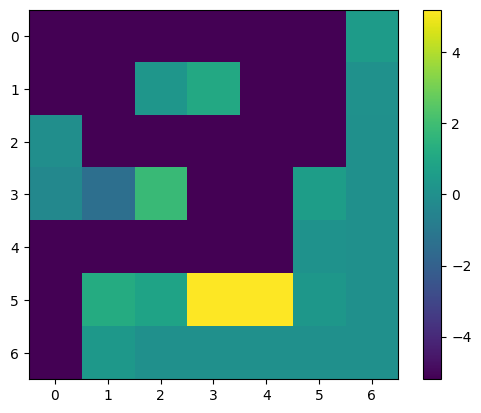

In [12]:
# Define the Tab2Img model
model_tab2img = Tab2Img()

""" In this stage, every sample in the data becomes a (9x9) numpy array. """
# Convert training data
X_train_images = model_tab2img.fit_transform(X_train_transformed, Y_train)

# Convert validation and test data (using the fitted model)
X_val_images  = model_tab2img.transform(X_val_transformed)
X_test_images = model_tab2img.transform(X_test_transformed)

""" In this stage, every array in the data becomes a (9x9x1) greyscale image. """
# Greyscale Transformation - Reshape the image data for CNN input
X_train_images = X_train_images.reshape(-1, 7, 7, 1)
X_val_images   = X_val_images.reshape(  -1, 7, 7, 1)
X_test_images  = X_test_images.reshape( -1, 7, 7, 1)

# Visualize an example
plt.imshow(X_train_images[0])
plt.colorbar()
plt.show()

In [13]:
import numpy as np
X_train_images = np.array(X_train_images)
X_test_images = np.array(X_test_images)
Y_train = np.array(Y_train)
Y_test_test = np.array(Y_test_test)

In [14]:
X_train_images.shape, Y_train.shape, X_test_images.shape, Y_test_test.shape

((81881, 7, 7, 1), (81881,), (31494, 7, 7, 1), (31494,))

In [15]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

# Parameters for Dirichlet distribution
num_clients = 10
num_samples = len(X_train_images)
num_classes = 5  # Number of classes in the NSL-KDD dataset
alpha = np.full(num_classes, 0.1) # Dirichlet concentration parameter

# Original class distribution for NSL-KDD
class_counts = np.array([67342, 5126, 45927, 13, 7564])  # Replace with actual counts

# Shuffle the data before partitioning
indices = np.arange(num_samples)
np.random.shuffle(indices)
X_train_images = X_train_images[indices]
Y_train = Y_train[indices]

# Partition the data into subsets for clients
client_data = [[] for _ in range(num_clients)]
client_labels = [[] for _ in range(num_clients)]
for i in range(num_samples):
    client_index = i % num_clients
    client_data[client_index].append(X_train_images[i])
    client_labels[client_index].append(Y_train[i])

# Generate non-IID data for each client
non_iid_data = []
non_iid_labels = []
for client_index in range(num_clients):
    client_data_np = np.array(client_data[client_index])
    client_labels_np = np.array(client_labels[client_index])

    # Generate probabilities for each class using Dirichlet distribution
    dirichlet_dist = tfp.distributions.Dirichlet(alpha)
    class_probs = dirichlet_dist.sample(1).numpy().reshape(-1)  # Sample one set of class probabilities

    # Scale class probabilities based on original class distribution
    scaled_probs = class_probs * class_counts / np.sum(class_probs * class_counts)

    # Calculate the number of samples for each class based on scaled probabilities
    class_counts_client = (scaled_probs * len(client_labels_np)).astype(int)

    # Adjust counts to match the desired total number of samples
    total_count = np.sum(class_counts_client)
    if total_count != len(client_labels_np):
        diff = len(client_labels_np) - total_count
        class_counts_client[np.argmax(class_counts_client)] += diff  # Add the difference to the class with the highest count

    # Cap the number of samples based on available data
    class_counts_client = np.minimum(class_counts_client, np.bincount(client_labels_np, minlength=num_classes))

    # Generate non-IID labels
    client_labels_non_iid = []
    for class_label, count in enumerate(class_counts_client):
        client_labels_non_iid.extend([class_label] * count)

    # Shuffle the labels to ensure randomness
    np.random.shuffle(client_labels_non_iid)

    non_iid_labels.append(np.array(client_labels_non_iid))

    # Generate non-IID data samples
    client_data_non_iid = []
    for label in client_labels_non_iid:
        label_indices = np.where(client_labels_np == label)[0]
        if len(label_indices) == 0:
            continue  # Skip this label if it doesn't exist in the client's dataset
        selected_index = np.random.choice(label_indices)
        client_data_non_iid.append(client_data_np[selected_index])

    non_iid_data.append(np.array(client_data_non_iid))

# Generate test set based on each client's non-IID data
non_iid_data_test = []
non_iid_labels_test = []
for client_index in range(num_clients):
    # Check if the client has non-empty data
    if len(non_iid_data[client_index]) == 0:
        continue

    # Use a portion of each client's non-IID data as the test set
    test_set_size = int(0.4 * len(non_iid_data[client_index]))
    test_indices = np.random.choice(len(non_iid_data[client_index]), test_set_size, replace=False)
    test_data = non_iid_data[client_index][test_indices]
    test_labels = non_iid_labels[client_index][test_indices]

    non_iid_data_test.append(test_data)
    non_iid_labels_test.append(test_labels)

# Concatenate test sets
non_iid_data_test = np.concatenate(non_iid_data_test, axis=0)
non_iid_labels_test = np.concatenate(non_iid_labels_test, axis=0)

# Convert lists to numpy arrays for further processing
non_iid_data = [np.array(data) for data in non_iid_data]
non_iid_labels = [np.array(labels) for labels in non_iid_labels]

# Print shapes of the generated data for verification
for i in range(num_clients):
    print(f"Client {i}: Data shape: {non_iid_data[i].shape}, Labels shape: {non_iid_labels[i].shape}")

print(f"Test data shape: {non_iid_data_test.shape}, Test labels shape: {non_iid_labels_test.shape}")





Client 0: Data shape: (868, 7, 7, 1), Labels shape: (868,)
Client 1: Data shape: (2930, 7, 7, 1), Labels shape: (2930,)
Client 2: Data shape: (324, 7, 7, 1), Labels shape: (324,)
Client 3: Data shape: (585, 7, 7, 1), Labels shape: (585,)
Client 4: Data shape: (808, 7, 7, 1), Labels shape: (808,)
Client 5: Data shape: (2942, 7, 7, 1), Labels shape: (2942,)
Client 6: Data shape: (3120, 7, 7, 1), Labels shape: (3120,)
Client 7: Data shape: (4158, 7, 7, 1), Labels shape: (4158,)
Client 8: Data shape: (3037, 7, 7, 1), Labels shape: (3037,)
Client 9: Data shape: (1158, 7, 7, 1), Labels shape: (1158,)
Test data shape: (7969, 7, 7, 1), Test labels shape: (7969,)


In [16]:
for i in range(num_clients):
    lst = [0 for _ in range(num_classes)]
    for j in range(len(non_iid_labels[i])):
        value = non_iid_labels[i][j]
        lst[value] += 1
    print(f"Client {i}: {lst}")


Client 0: [0, 0, 366, 0, 502]
Client 1: [17, 0, 2913, 0, 0]
Client 2: [0, 314, 9, 1, 0]
Client 3: [61, 357, 167, 0, 0]
Client 4: [0, 354, 0, 1, 453]
Client 5: [0, 13, 2929, 0, 0]
Client 6: [0, 0, 3120, 0, 0]
Client 7: [418, 286, 2947, 0, 507]
Client 8: [0, 348, 2689, 0, 0]
Client 9: [0, 343, 339, 0, 476]


In [17]:
from keras.layers import Dense, GRU, Flatten, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
from tensorflow.keras.regularizers import l2

# input_shape = (9,9,1)
num_classes = 5
class Model:
    def __init__(self, loss, optimizer, num_classes):
        self.loss = loss
        self.optimizer = optimizer
        self.num_classes = num_classes

    def fl_paper_model(self,train_shape):

          conv_initializer   = HeNormal(seed=seed_pi)
          dense_initializer  = HeUniform(seed=seed_pi)
          output_initializer = GlorotUniform(seed=seed_pi)
          mlp = Sequential([
          Input(shape=(7, 7, 1)),

          Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer=conv_initializer),
          MaxPooling2D(pool_size=(2, 2)),
          Flatten(),
          Dense(128, activation='relu', kernel_initializer=dense_initializer),
          BatchNormalization(),
          Dropout(.01),
          # Dense(16, activation='relu', kernel_initializer=dense_initializer),

          Dense(num_classes, activation='softmax', kernel_initializer=output_initializer)
      ])
          mlp.compile(loss=self.loss, optimizer=self.optimizer, metrics=['accuracy'])
          return mlp

Client 0: [4368, 317, 0, 0, 0]
Client 1: [0, 0, 1, 1, 479]
Client 2: [0, 0, 3013, 1, 0]
Client 3: [697, 102, 3040, 0, 8]
Client 4: [4169, 1, 0, 0, 502]
Client 5: [0, 333, 1512, 0, 0]
Client 6: [701, 34, 2912, 0, 0]
Client 7: [4405, 8, 0, 0, 496]
Client 8: [0, 317, 3015, 0, 423]
Client 9: [0, 340, 3002, 0, 506]
Shape of a single data point: (7,)
particle 1/10 fitting
Epoch 1/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.1717 - loss: 2.0961 - val_accuracy: 0.0000e+00 - val_loss: 8.2600 - learning_rate: 2.0000e-04
Epoch 2/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3899 - loss: 1.7342 - val_accuracy: 0.0000e+00 - val_loss: 5.1694 - learning_rate: 2.0000e-04
Epoch 3/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5015 - loss: 1.5464 - val_accuracy: 0.0000e+00 - val_loss: 3.4802 - learning_rate: 2.0000e-04
Epoch 4/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5739 - loss: 1.4178 - val_accuracy: 0.0064 - val_loss: 2.2315 - learning_rate: 2.0000e-04
Epo

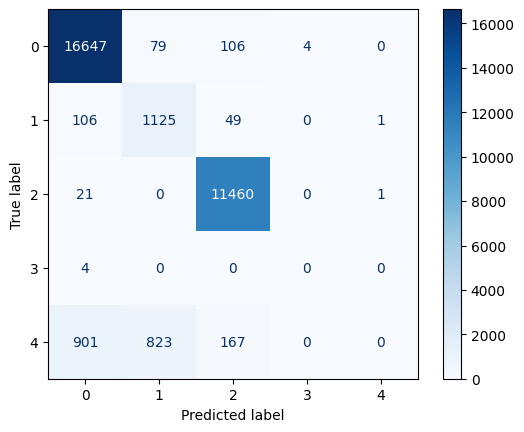

: 

In [21]:
# Global configuration
from tensorflow.keras.optimizers import Adam, SGD
NUMOFCLIENTS = 10  # number of clients (particles)
EPOCHS = 30  # number of total iterations
CLIENT_EPOCHS = 5  # number of each client's iterations
BATCH_SIZE = 256 # Size of batches to train on
ACC = 0.5
LOCAL_ACC = 0.9
GLOBAL_ACC = 1.4
DROP_RATE = 0
# Model configuration
LOSS = 'sparse_categorical_crossentropy'
NUMOFCLASSES = 5
# lr = 0.000025
lr = 0.0002
OPTIMIZER = Adam(learning_rate=lr)
# OPTIMIZER = SGD(learning_rate=lr, momentum=0.9, nesterov=False)

# Function to write results to CSV
def write_csv(algorithm_name, list):
    file_name = '{name}_10Clients_{drop}%_output_LR_{lr}_CLI_{cli}_CLI_EPOCHS_{cli_epoch}_TOTAL_EPOCHS_{epochs}_BATCH_{batch}.csv'
    file_name = file_name.format(drop=DROP_RATE, name=algorithm_name, lr=lr, cli=NUMOFCLIENTS, cli_epoch=CLIENT_EPOCHS, epochs=EPOCHS, batch=BATCH_SIZE)
    f = open(file_name, 'w', encoding='utf-8', newline='')
    wr = csv.writer(f)

    for l in list:
        wr.writerow(l)
    f.close()

def init_model(train_data_shape):
    model = Model(loss=LOSS, optimizer=OPTIMIZER,num_classes=NUMOFCLASSES)
    init_model = model.fl_paper_model(train_shape=train_data_shape)

    return init_model

def client_data_config(non_iid_data, non_iid_labels, num_clients):
    client_data = []
    for i in range(num_clients):
        x_data, y_data = non_iid_data[i], non_iid_labels[i]
        client_data.append((x_data, y_data))

    return client_data
class particle():
    def __init__(self, particle_num, client, x_train, y_train):
        # for check particle id
        self.particle_id = particle_num

        # particle model init
        self.particle_model = client

        # best model init
        self.local_best_model = client
        self.global_best_model = client

        # best score init
        self.local_best_score = 0.0
        self.global_best_score = 0.0

        self.x = x_train
        self.y = y_train

        # acc = acceleration
        self.parm = {'acc':ACC, 'local_acc':LOCAL_ACC, 'global_acc':GLOBAL_ACC}

        # velocities init
        self.velocities = [None] * len(client.get_weights())
        for i, layer in enumerate(client.get_weights()):
            self.velocities[i] = np.random.rand(*layer.shape) / 5 - 0.10

    def train_particle(self):
        print("particle {}/{} fitting".format(self.particle_id+1, NUMOFCLIENTS))

        # set each epoch's weight
        step_model = self.particle_model
        step_weight = step_model.get_weights()

        # new_velocities = [None] * len(step_weight)
        new_weight = [None] * len(step_weight)
        local_rand, global_rand = random.random(), random.random()

        # PSO algorithm applied to weights
        for index, layer in enumerate(step_weight):
            new_v = self.parm['acc'] * self.velocities[index]
            new_v = new_v + self.parm['local_acc'] * local_rand * (self.local_best_model.get_weights()[index] - layer)
            new_v = new_v + self.parm['global_acc'] * global_rand * (self.global_best_model.get_weights()[index] - layer)
            self.velocities[index] = new_v
            new_weight[index] = step_weight[index] + self.velocities[index]

        optimizer = Adam(learning_rate=lr)
        step_model.compile(optimizer=optimizer, loss=LOSS, metrics=['accuracy'])

        step_model.set_weights(new_weight)

        # Recreate the optimizer to avoid the error

        # 4.2 - Early Stopping, Learning Rate Scheduler and Compiling
        # save_model_path = 'checkpoint/checkpoint_particle_{}.weights.h5'.format(self.particle_id)
        save_model_path = 'checkpoint_1/checkpoint_particle_{}.weights.h5'.format(self.particle_id)

        mc = ModelCheckpoint(filepath=save_model_path,
                            monitor='val_loss',
                            mode='min',
                            save_best_only=True,
                            save_weights_only=True)

        early_stopping = EarlyStopping(
            monitor='accuracy',
            patience=10,
            verbose=1,
            restore_best_weights=True)

        reduce_lr = ReduceLROnPlateau(
            monitor='accuracy',
            patience=5,
            min_lr=1e-04,
            verbose=1,
            factor=0.1)

        hist = step_model.fit(x=self.x, y=self.y,
                              epochs=CLIENT_EPOCHS,
                              batch_size=BATCH_SIZE,
                              verbose=1,
                              validation_split=0.1,
                              callbacks=[mc,reduce_lr,early_stopping])

        train_score_loss = hist.history['val_loss'][-1]

        step_model.load_weights(save_model_path)
        self.particle_model = step_model

        if self.global_best_score >= train_score_loss:
            self.local_best_model = step_model

        return self.particle_id, train_score_loss

    def update_global_model(self, global_best_model, global_best_score):
        if self.local_best_score < global_best_score:
            self.global_best_model = global_best_model
            self.global_best_score = global_best_score

    def resp_best_model(self, gid):
        if self.particle_id == gid:
            return self.particle_model


def get_best_score_by_loss(step_result):
    # step_result = [[step_model, train_socre_acc],...]
    temp_score = 100000
    temp_index = 0

    for index, result in enumerate(step_result):
        if temp_score > result[1]:
            temp_score = result[1]
            temp_index = index

    return step_result[temp_index][0], step_result[temp_index][1]


def get_best_score_by_acc(step_result):
    # step_result = [[step_model, train_socre_acc],...]
    temp_score = 0
    temp_index = 0

    for index, result in enumerate(step_result):
        if temp_score < result[1]:
            temp_score = result[1]
            temp_index = index

    return step_result[temp_index][0], step_result[temp_index][1]

if __name__ == "__main__":

    x_train = non_iid_data
    y_train = non_iid_labels
    x_test = X_test_images
    y_test = Y_test_test


    for i in range(NUMOFCLIENTS):
        lst = [0 for _ in range(NUMOFCLASSES)]
        for j in range(len(non_iid_labels[i])):
            value = non_iid_labels[i][j]
            lst[value] += 1
        print(f"Client {i}: {lst}")


    train_data_shape = (x_train[0].shape[1],)
    print("Shape of a single data point:", train_data_shape)
    client_data = client_data_config(x_train, y_train, NUMOFCLIENTS)

    server_model = init_model(train_data_shape=train_data_shape)
    # print(server_model.summary())

    pso_model = []
    for i in range(NUMOFCLIENTS):
        pso_model.append(particle(particle_num=i, client=init_model(train_data_shape = x_train[0].shape[1]), x_train=client_data[i][0], y_train=client_data[i][1]))

    server_evaluate_acc = []
    global_best_model = None
    global_best_score = 0.0

    for epoch in range(EPOCHS):
        server_result = []
        start = time.time()

        for client in pso_model:
            if epoch != 0:
                client.update_global_model(server_model, global_best_score)

            pid, train_score = client.train_particle()
            rand = random.randint(0, 99)

            drop_communication = range(DROP_RATE)
            if rand not in drop_communication:
                server_result.append([pid, train_score])

        gid, global_best_score = get_best_score_by_loss(server_result)
        for client in pso_model:
            if client.resp_best_model(gid) != None:
                global_best_model = client.resp_best_model(gid)

        server_model = global_best_model

        print("server {}/{} evaluate".format(epoch + 1, EPOCHS))
        server_evaluate_acc.append(server_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=1))

    write_csv("FedPSO_NSLKDD_Dritchlit", server_evaluate_acc)

import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(server_model.predict(x_test), axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.arange(NUMOFCLASSES))

# Print the confusion matrix
print("Confusion Matrix :")
print(cm)

# Optionally visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(NUMOFCLASSES)])
disp.plot(cmap=plt.cm.Blues)
plt.show()

'''Confusion Matrix FedPSO_NSLKDD_Dritchlit :
[[16647    79   106     4     0]
 [  106  1125    49     0     1]
 [   21     0 11460     0     1]
 [    4     0     0     0     0]
 [  901   823   167     0     0]] '''

Client 0: [0, 0, 366, 0, 502]
Client 1: [17, 0, 2913, 0, 0]
Client 2: [0, 314, 9, 1, 0]
Client 3: [61, 357, 167, 0, 0]
Client 4: [0, 354, 0, 1, 453]
Client 5: [0, 13, 2929, 0, 0]
Client 6: [0, 0, 3120, 0, 0]
Client 7: [418, 286, 2947, 0, 507]
Client 8: [0, 348, 2689, 0, 0]
Client 9: [0, 343, 339, 0, 476]
Shape of a single data point: (7,)
client 1/10 fitting
Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.2225 - loss: 1.7330 - val_accuracy: 0.3103 - val_loss: 11.2256
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6949 - loss: 0.9469 - val_accuracy: 0.3060 - val_loss: 7.6729
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8207 - loss: 0.6485 - val_accuracy: 0.3060 - val_loss: 5.6315
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8677 - loss: 0.4940 - val_accuracy: 0.3060 - val_loss: 4.4118
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8916 - loss: 0.3948 - val_accuracy: 0.3060 - val_loss: 3.7751
client 2/10 fitti

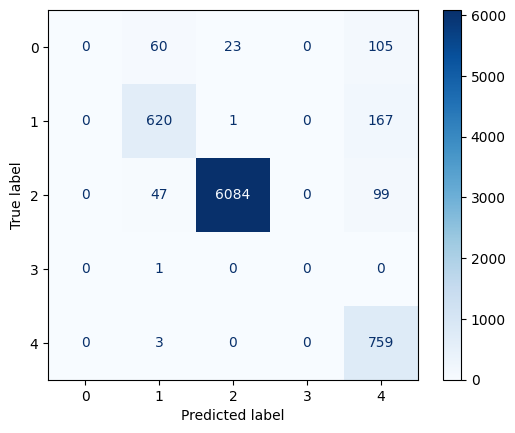

In [19]:
# Global configuration
from tensorflow.keras.optimizers import Adam, SGD

# Global configuration
NUMOFCLIENTS = 10  # number of clients (particles)
EPOCHS = 30  # number of total iterations
CLIENT_EPOCHS = 5  # number of each client's iterations
BATCH_SIZE = 256 # Size of batches to train on
ACC = 0.3
LOCAL_ACC = 0.7
GLOBAL_ACC = 1.4
DROP_RATE = 0
SELECT_CLIENTS = 1
# Model configuration
LOSS = 'sparse_categorical_crossentropy'
NUMOFCLASSES = 5
lr = 0.0002
# lr = 0.001
OPTIMIZER = Adam(learning_rate=lr)
# OPTIMIZER = SGD(learning_rate=lr, momentum=0.9, nesterov=False)

# Function to write results to CSV
def write_csv(algorithm_name, list):
    file_name = '{name}_FedAvg_10Clients_{drop}%_output_LR_{lr}_CLI_{cli}_CLI_EPOCHS_{cli_epoch}_TOTAL_EPOCHS_{epochs}_BATCH_{batch}.csv'
    file_name = file_name.format(drop=DROP_RATE, name=algorithm_name, lr=lr, cli=NUMOFCLIENTS, cli_epoch=CLIENT_EPOCHS, epochs=EPOCHS, batch=BATCH_SIZE)
    f = open(file_name, 'w', encoding='utf-8', newline='')
    wr = csv.writer(f)

    for l in list:
        wr.writerow(l)
    f.close()

def init_model(train_data_shape):
    model = Model(loss=LOSS, optimizer=OPTIMIZER,num_classes=NUMOFCLASSES)
    init_model = model.fl_paper_model(train_shape=train_data_shape)

    return init_model

def client_data_config(non_iid_data, non_iid_labels, num_clients):
    client_data = []
    for i in range(num_clients):
        x_data, y_data = non_iid_data[i], non_iid_labels[i]
        client_data.append((x_data, y_data))

    return client_data


def fedAVG(server_weight):
    avg_weight = [np.zeros_like(w) for w in server_weight[0]]  # Initialize with the same structure as the first set of weights

    for client_weights in server_weight:
        for i, w in enumerate(client_weights):
            avg_weight[i] += w

    avg_weight = [w / len(server_weight) for w in avg_weight]  # Compute the average

    return avg_weight

def client_update(index, client, now_epoch, avg_weight):
    print("client {}/{} fitting".format(index + 1, int(NUMOFCLIENTS * SELECT_CLIENTS)))

    optimizer = tf.keras.optimizers.Adam()
    client.compile(optimizer=optimizer, loss=LOSS, metrics=['accuracy'])
    if now_epoch != 0:
        client.set_weights(avg_weight)

    client.fit(client_data[i][0], client_data[i][1],
        epochs=CLIENT_EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_split=0.2,
    )

    return client

if __name__ == "__main__":

    x_train = non_iid_data
    y_train = non_iid_labels
    x_test = non_iid_data_test
    y_test = non_iid_labels_test


    for i in range(NUMOFCLIENTS):
        lst = [0 for _ in range(NUMOFCLASSES)]
        for j in range(len(non_iid_labels[i])):
            value = non_iid_labels[i][j]
            lst[value] += 1
        print(f"Client {i}: {lst}")


    train_data_shape = (x_train[0].shape[1],)
    print("Shape of a single data point:", train_data_shape)
    client_data = client_data_config(x_train, y_train, NUMOFCLIENTS)
    server_model = init_model(train_data_shape=train_data_shape)
    
    fl_model = []
    for i in range(NUMOFCLIENTS):  # Keys are now starting from 0
        optimizer = Adam(learning_rate=lr)
        fl_model.append(init_model(train_data_shape=train_data_shape,))

    avg_weight = [np.zeros_like(w) for w in server_model.get_weights()]

    server_evaluate_acc = []

    for epoch in range(EPOCHS):
        server_weight = []

        selected_num = int(max(NUMOFCLIENTS * SELECT_CLIENTS, 1))
        split_data_index = []
        while len(split_data_index) < selected_num:
            item = random.choice(range(len(fl_model)))
            if item not in split_data_index:
                split_data_index.append(item)
        split_data_index.sort()
        selected_model = [fl_model[k] for k in split_data_index]

        for index, client in enumerate(selected_model):
            recv_model = client_update(index, client, epoch, avg_weight)

            rand = random.randint(0, 99)
            drop_communication = range(DROP_RATE)
            if rand not in drop_communication:
                server_weight.append(copy.deepcopy(recv_model.get_weights()))

        avg_weight = fedAVG(server_weight)

        server_model.set_weights(avg_weight)
        print("server {}/{} evaluate".format(epoch + 1, EPOCHS))
        server_evaluate_acc.append(server_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=1))

    write_csv("FedAvg_NSLKDD_Dritchlit", server_evaluate_acc)

import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(server_model.predict(x_test), axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.arange(NUMOFCLASSES))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optionally visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(NUMOFCLASSES)])
disp.plot(cmap=plt.cm.Blues)
plt.show()

'''Confusion Matrix FedAvg_NSLKDD_Dritchlit:
[[   0   60   23    0  105]
 [   0  620    1    0  167]
 [   0   47 6084    0   99]
 [   0    1    0    0    0]
 [   0    3    0    0  759]]'''


In [ ]:
# Global configuration
from tensorflow.keras.optimizers import Adam, SGD

NUMOFCLIENTS = 10 # number of clients (particles)
EPOCHS = 20  # number of total iterations
CLIENT_EPOCHS = 5  # number of each client's iterations
BATCH_SIZE = 256 # Size of batches to train on
ACC = 0.3
LOCAL_ACC = 0.7
GLOBAL_ACC = 1.4
DROP_RATE = 0
SELECT_CLIENTS = 1
# Model configuration
# LOSS = 'binary_crossentropy'
LOSS = 'sparse_categorical_crossentropy'
NUMOFCLASSES = 7
lr = 0.00001
# lr = 0.0001
OPTIMIZER = Adam(learning_rate=lr)
# OPTIMIZER = SGD(learning_rate=lr, momentum=0.9, nesterov=False)

# Function to write results to CSV
def write_csv(algorithm_name, list):
    file_name = '{name}_FedAvg_10Clients_{drop}%_output_LR_{lr}_CLI_{cli}_CLI_EPOCHS_{cli_epoch}_TOTAL_EPOCHS_{epochs}_BATCH_{batch}.csv'
    file_name = file_name.format(drop=DROP_RATE, name=algorithm_name, lr=lr, cli=NUMOFCLIENTS, cli_epoch=CLIENT_EPOCHS, epochs=EPOCHS, batch=BATCH_SIZE)
    f = open(file_name, 'w', encoding='utf-8', newline='')
    wr = csv.writer(f)

    for l in list:
        wr.writerow(l)
    f.close()

def init_model(train_data_shape):
    model = CustomModel(loss=LOSS, optimizer=OPTIMIZER,num_classes=NUMOFCLASSES)
    init_model = model.fl_paper_model(train_shape=train_data_shape)

    return init_model

import numpy as np

def client_data_config(x_train, y_train):
    num_clients = NUMOFCLIENTS
    num_samples = x_train.shape[0]
    num_per_client = num_samples // num_clients

    # Generate a random permutation of indices
    indices = np.random.permutation(num_samples)

    # Split indices into chunks for each client
    client_indices = np.array_split(indices, num_clients)

    # Prepare client data
    client_data = []
    data_distributions = []

    for i, idxs in enumerate(client_indices):
        new_x_train = x_train[idxs]
        new_y_train = y_train[idxs]

        client_data.append((new_x_train, new_y_train))

        # Record the data distribution for the client
        class_counts = np.bincount(new_y_train)
        class_distribution = {cls: count for cls, count in enumerate(class_counts) if count > 0}

        data_distribution = {
            'client_index': i,
            'num_samples': len(idxs),
            'classes_distribution': class_distribution
        }
        data_distributions.append(data_distribution)

    # Print the data distribution for each client
    for dist in data_distributions:
        print(f"Client {dist['client_index']}:")
        print(f"  Number of samples: {dist['num_samples']}")
        print(f"  Class distribution: {dist['classes_distribution']}")
        print()

    return client_data

def fedAVG(server_weight):
    avg_weight = [np.zeros_like(w) for w in server_weight[0]]  # Initialize with the same structure as the first set of weights

    for client_weights in server_weight:
        for i, w in enumerate(client_weights):
            avg_weight[i] += w

    avg_weight = [w / len(server_weight) for w in avg_weight]  # Compute the average

    return avg_weight

def client_update(index, client, now_epoch, avg_weight):
    print("client {}/{} fitting".format(index + 1, int(NUMOFCLIENTS * SELECT_CLIENTS)))

    optimizer = tf.keras.optimizers.Adam()
    client.compile(optimizer=optimizer, loss=LOSS, metrics=['accuracy'])
    if now_epoch != 0:
        client.set_weights(avg_weight)

    client.fit(client_data[index][0], client_data[index][1],
        epochs=CLIENT_EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_split=0.2,
    )

    return client

if __name__ == "__main__":

    x_train = X_train_images
    y_train = Y_train
    x_test = X_test_images
    y_test = Y_test_test

    train_data_shape = (x_train[0].shape[1],)
    print("Shape of a single data point:", train_data_shape)
    client_data = client_data_config(x_train, y_train)

    server_model = init_model(train_data_shape=train_data_shape)
    print(server_model.summary())

    fl_model = []
    for i in range(NUMOFCLIENTS):  # Keys are now starting from 0
        optimizer = Adam(learning_rate=lr)
        fl_model.append(init_model(train_data_shape=train_data_shape,))

    avg_weight = [np.zeros_like(w) for w in server_model.get_weights()]

    server_evaluate_acc = []

    for epoch in range(EPOCHS):
        server_weight = []

        selected_num = int(max(NUMOFCLIENTS * SELECT_CLIENTS, 1))
        split_data_index = []
        while len(split_data_index) < selected_num:
            item = random.choice(range(len(fl_model)))
            if item not in split_data_index:
                split_data_index.append(item)
        split_data_index.sort()
        selected_model = [fl_model[k] for k in split_data_index]

        for index, client in enumerate(selected_model):
            recv_model = client_update(index, client, epoch, avg_weight)

            rand = random.randint(0, 99)
            drop_communication = range(DROP_RATE)
            if rand not in drop_communication:
                server_weight.append(copy.deepcopy(recv_model.get_weights()))

        avg_weight = fedAVG(server_weight)

        server_model.set_weights(avg_weight)
        print("server {}/{} evaluate".format(epoch + 1, EPOCHS))
        server_evaluate_acc.append(server_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=1))

    write_csv("FedAvg_iid", server_evaluate_acc)